In [ ]:
!pip install livelossplot

In [16]:
import os
import gc
import numpy as np
import pandas as pd
import pickle
import random
import torch
from livelossplot import PlotLosses
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler, random_split
from transformers import BertForMaskedLM, AutoTokenizer, AutoModel, DataCollatorForLanguageModeling, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import warnings
import torch
import gc

warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_citation_text_id(df):
    """
    Generates a unique ID for each unique cited text combination in the DataFrame.

    This function adds a new column to the DataFrame, 'cited_text', which is a combination
    of 'left_cited_text' and 'right_cited_text'. It then creates a mapping from each unique
    cited text to a unique ID and assigns these IDs to a new column, 'cited_text_id'.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the citation texts.

    Returns:
    - pd.DataFrame: The original DataFrame augmented with 'cited_text' and 'cited_text_id' columns.
    """

    # Combine the left and right cited text with a space in between to form a complete citation
    df['citated_text'] = df['left_citated_text'] + " " + df['right_citated_text']

    # Create a dictionary mapping each unique cited text to a unique ID
    # Using enumerate ensures each cited text gets a unique, sequential ID
    cited_voca = {text: id_ for id_, text in enumerate(df['citated_text'].unique())}

    # Map the cited texts in the DataFrame to their respective IDs
    # The mapping uses the dictionary created above
    df['citated_text_id'] = df['citated_text'].map(cited_voca)

    return df

def data_preprocess(data):
    """
    Loads a dataset from a CSV file and preprocesses it by assigning unique IDs to citation texts.

    Parameters:
    - data (str or pd.DataFrame): The path to the CSV file containing the dataset or a DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with the preprocessing applied.
    - None: If the file is not found or an error occurs during loading.
    """
    # Validate input
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    elif isinstance(data, str):
        try:
            df = pd.read_csv(data)
        except FileNotFoundError:
            print(f"CSV file '{data}' not found.")
            return None
        except Exception as e:
            print(f"An error occurred while loading the CSV file: {e}")
            return None
    else:
        print("Input type for 'data' is not recognized. Please provide a file path or a DataFrame.")
        return None

    # Assuming get_citation_text_id is a function that you've defined elsewhere
    try:
        df = get_citation_text_id(df)
    except Exception as e:
        print(f"An error occurred during preprocessing: {e}")
        return None

    return df

In [5]:
df = data_preprocess('/content/full_context_PeerRead.csv')

In [6]:
model_name = "allenai/scibert_scivocab_uncased"

model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [7]:
class MLMDataLoader(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mlm_probability = mlm_probability
        self.dataframe = dataframe

        self.concatenated_texts = self.dataframe.apply(
            lambda row: ' '.join([
                str(row.get('source_abstract', '')),
                str(row.get('right_citated_text', '')),
                str(row.get('left_citated_text', '')),
                str(row.get('source_title', '')),
                str(row.get('target_abstract', '')),
                str(row.get('target_title', '')),
                str(row.get('citated_text', ''))
                ]), axis=1).tolist()

        self.inputs = []
        self.labels = []

        for text in self.concatenated_texts:
            # Tokenize text with special tokens
            inputs = tokenizer.encode_plus(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
            input_ids = inputs['input_ids'].squeeze()  # Remove batch dimension

            # Apply token masking
            input_ids, labels = self.mask_tokens(input_ids.numpy())

            self.inputs.append(torch.tensor(input_ids))
            self.labels.append(torch.tensor(labels))

    def mask_tokens(self, input_ids):
        """Prepare masked tokens inputs/labels for masked language modeling."""
        # Convert to a list if not already (assuming input_ids is a numpy array)
        input_ids_list = input_ids.tolist()

        labels = np.copy(input_ids)
        # Probability matrix for masking
        probability_matrix = np.full(labels.shape, self.mlm_probability)

        # Generating a special tokens mask
        special_tokens_mask = [int(token in self.tokenizer.all_special_ids) for token in input_ids_list]

        # Applying the special tokens mask to the probability matrix
        probability_matrix = np.where(np.array(special_tokens_mask, dtype=bool), 0, probability_matrix)

        # Choosing tokens to mask
        masked_indices = np.random.rand(*labels.shape) < probability_matrix
        labels[~masked_indices] = -100  # We only compute loss on masked tokens

        # Replace 80% of masked tokens with [MASK]
        indices_replaced = (np.random.rand(*labels.shape) < 0.8) & masked_indices
        input_ids[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # Replace 10% of masked tokens with random token
        indices_random = (np.random.rand(*labels.shape) < 0.1) & masked_indices & ~indices_replaced
        random_tokens = np.random.randint(len(self.tokenizer), size=len(labels))
        input_ids[indices_random] = random_tokens[indices_random]

        # The remaining 10% of masked tokens remain the same, so no action is needed for them

        return input_ids, labels


    def __len__(self):
        return len(self.concatenated_texts)

    def __getitem__(self, idx):
      inputs = self.inputs[idx]
      labels = self.labels[idx]
      return {"input_ids": inputs, "attention_mask": (inputs != self.tokenizer.pad_token_id).long(), "labels": labels}


In [17]:
def train_model(n_epochs, model, optimizer, scheduler, train_loader, val_loader, accumulation_steps):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    scaler = GradScaler()

    best_val_loss = float('inf')
    liveloss = PlotLosses()

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        cumulative_loss = 0
        n_samples = 0

        logs = {}
        for i, batch in enumerate(train_loader):
            batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}

            with autocast():  # Mixed precision
                outputs = model(**batch)
                loss = outputs.loss / accumulation_steps

            scaler.scale(loss).backward()  # Scaled backpropagation

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            cumulative_loss += loss.item() * accumulation_steps  # Undo the averaging
            n_samples += 1

        avg_train_loss = cumulative_loss / n_samples
        logs['loss'] = avg_train_loss

        # Validation Step
        model.eval()
        val_cumulative_loss = 0
        n_val_samples = 0


        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}

                with autocast():  # Mixed precision for validation step as well
                    outputs = model(**batch)
                    loss = outputs.loss

                val_cumulative_loss += loss.item()
                n_val_samples += 1

        avg_val_loss = val_cumulative_loss / n_val_samples
        logs['val_loss'] = avg_val_loss

        # Update best model (based on val_loss or another metric)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        liveloss.update(logs)
        liveloss.send()

        if scheduler is not None:
            scheduler.step()

    model.load_state_dict(torch.load('best_model.pth'))

In [18]:
batch_size = 8
train_df, val_df = train_test_split(df, test_size=0.3)

train_dataset = MLMDataLoader(train_df, tokenizer=tokenizer)
val_dataset = MLMDataLoader(val_df, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

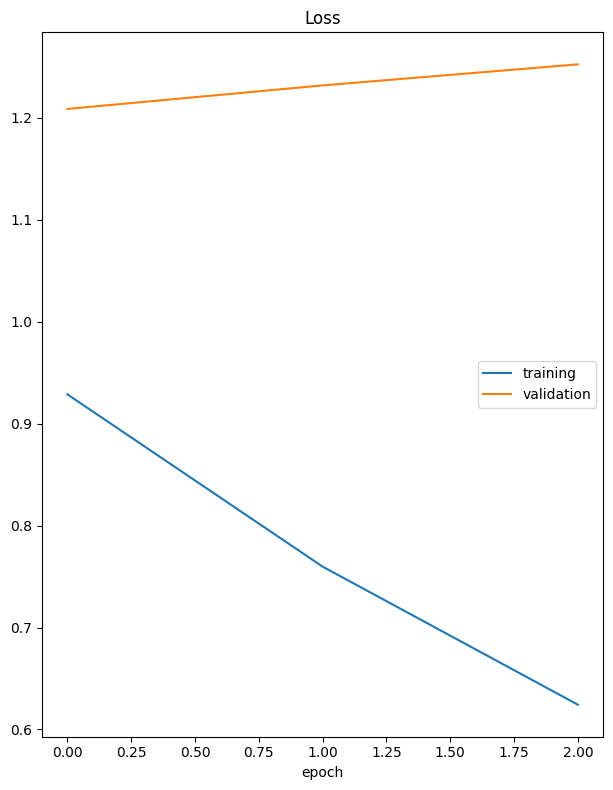

Loss
	training         	 (min:    0.624, max:    0.929, cur:    0.624)
	validation       	 (min:    1.209, max:    1.252, cur:    1.252)


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Define hyperparameters
n_epochs = 40
accumulation_steps = 4
learning_rate = 5e-5
total_steps = len(train_loader) * n_epochs
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Call the train_model function
train_model(
    n_epochs=n_epochs,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    accumulation_steps=accumulation_steps
)

In [ ]:
from google.colab import files

# Make sure the file exists
!ls -lh best_model.pth

# Trigger the download
files.download('best_model.pth')